In [1]:
import time
import sys
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()
from pandas_datareader.yahoo.headers import DEFAULT_HEADERS
import datetime
import requests_cache
import numpy as np

expire_after = datetime.timedelta(days=3)
session = requests_cache.CachedSession(cache_name='cache', backend='sqlite', expire_after=expire_after)
session.headers = DEFAULT_HEADERS

# from typing import List, Optional
import os
import pickle 
from tqdm import tqdm
# import scipy.stats as sp
from scipy.stats import skew, kurtosis, shapiro
# from utils import *
import matplotlib.pyplot as plt
# import math

%matplotlib inline

import statsmodels.formula.api as smf
sys.path.append('../')
from backtrader_app.backtest import run_backtest

import statsmodels.api as sm
from bs4 import BeautifulSoup
import requests
# tickers = ['AAPL','AMZN','TSLA','GOOG']
# ticker = tickers[0]
# info = yfin.Ticker(ticker).info
# info

In [39]:

current_date = datetime.datetime.now()
current_date_formatted = current_date.strftime("%Y-%m-%d")
first_day_of_year = datetime.datetime(
    current_date.year, 1, 1)
first_day_of_year_formatted = datetime.datetime(
    current_date.year, 1, 1).strftime("%Y-%m-%d")


def print_nice_dictionary(data_dict):
    for key, value in data_dict.items():
        if isinstance(value, tuple):
            value = f'{value[0]}(statistic), {value[1]}(pvalue)'
        print(f"{key}: {value}")

# UNUSED. Another way to get monthly returns but uses the first and last day of a month instead of first day of the next month
def custom_monthly_return(resampled_data):
    first_day_return = resampled_data['total'].iloc[0]
    last_day_return = resampled_data['total'].iloc[-1]
    if pd.notna(first_day_return) and pd.notna(last_day_return) and first_day_return != 0:
        monthly_return = (last_day_return - first_day_return) / first_day_return
        return monthly_return
    else:
        return pd.NA
    
# For converting a number like 1K to 1000 from cnbc.com market caps
def convert_to_number(string):
    suffixes = {
        'K': 10**3,
        'M': 10**6,
        'B': 10**9,
        'T': 10**12
    }

    try:
        # Check if the last character is a letter denoting suffix
        suffix = string[-1]
        if suffix in suffixes:
            # Convert the string without the suffix into a float
            number = float(string[:-1])
            # Multiply by the appropriate factor based on the suffix
            number *= suffixes[suffix]
        else:
            # If there's no suffix, simply convert the string into a float
            number = float(string)
    except ValueError:
        print("Invalid input format")
        return None

    return number
    
class Stock:
    def __init__(self, ticker, start=first_day_of_year_formatted, end=current_date_formatted, df=None, initial_capital=1000, path=r"/Users/lucasmoyer/development/two-dolla/stocks.pkl", save_new=True, debug=False):
        self.ticker = ticker
        self.initial_capital = initial_capital
        self.isBankrupt = 0
        self.path = path
        self.savedBars = None
        self.df = df
        self.start = start
        self.end = end
        self.positionOutCash = False
        self.strategies = []
        self.debug = debug
        self.save_new = save_new
        self.sum_stats = None

        with open(self.path, 'rb') as handle:
            self.savedBars = pickle.load(handle)
            if self.debug:
                print("saved bars")
                print(self.savedBars.keys())
            if ticker in self.savedBars:
                if self.debug:
                    print("ticker exists in savedBars")
                self.df = self.savedBars[ticker]
        if (self.df is None or save_new):
            if self.debug:
                print('getting new data')

            self.df = self.getStocksData(ticker,start=self.start,end=self.end,save_new=True)

        self.bars = self.df
        self.positions = pd.DataFrame(self.df.index)
        self.sum_stats = self.get_sum_stats(self.ticker)

    def getSavedData(self, ticker):
        with open(self.path, 'rb') as handle:
            stocks = pickle.load(handle)
            if self.ticker in stocks:
                return stocks[self.ticker]
            else:
                return None

    # gets stock ticket data for current day
    def getStocksData(self, tickers, start=first_day_of_year_formatted, end=current_date_formatted, save_new=False, saveToCSV=True):
        # check if data exists, if not pull data
        if (self.save_new or self.ticker not in self.savedBars):

            try:
                if (self.debug):
                    print(f"Trying download of {self.ticker}")
                stock_data = pdr.get_data_yahoo(
                    self.ticker, start=start, end=end, session=session)
                stock_data = stock_data.reset_index()
                if (self.debug):
                    print(f"Downloaded bars of {self.ticker}")
                if saveToCSV:
                    path = "/Users/lucasmoyer/development/two-dolla/datasets/stock_csvs"
                    stock_data.to_csv(
                        f'{path + "/" + self.ticker}.csv', index=False, encoding='utf-8')
                self.savedBars[self.ticker] = stock_data
                with open(self.path, 'wb') as handle:
                    pickle.dump(self.savedBars, handle,
                                protocol=pickle.HIGHEST_PROTOCOL)
                return stock_data
            except:
                print("Skipping stock for {}, bad data :<".format(self.ticker))
        else:
            return self.savedBars[self.ticker]

    def get_sum_stats(self,symbol):
        try:
            stat_dict = {}
            url = f'https://www.cnbc.com/quotes/{symbol}?tab=news'
            html = requests.get(url).content
            soup = BeautifulSoup(html, 'html.parser')
            sum_stats = soup.find_all('li', {'class': 'Summary-stat'})
            stat_dict = {}
            for stat in sum_stats:
                label = stat.find('span', {'class': 'Summary-label'}).text
                value = stat.find('span', {'class': 'Summary-value'}).text

                if label == "Market Cap":
                    value = convert_to_number(value)
                stat_dict[label] = value
                stat_dict['date'] = datetime.datetime.now()
            return stat_dict
        except Exception as e:
            print(f"Error processing {symbol}: {str(e)}")
            return {}

    def addStrategy(self, func):
        self.strategies.append(func)

    def viewStrategies(self):
        for x in self.strategies:
            print(x)

    def backtest(self):
        strategies = self.strategies

        self.positions[self.ticker +
                       '_position'] = pd.concat(strategies).groupby(level=0).mean()
        self.positions[self.ticker + '_position'].at[0] = 0
        self.positions[self.ticker + '_open'] = self.bars.Open
        self.positions[self.ticker + '_close'] = self.bars.Close
        self.positions['date'] = self.bars.Date

        self.positions[self.ticker +
                       '_pos_diff'] = self.positions[self.ticker + "_position"].diff()
        self.positions[self.ticker + "_holdings"] = 0
        self.positions[self.ticker + "_pos_diff"].at[0] = 0
        self.positions.at[0, f"{self.ticker}_cash"] = self.initial_capital

        for index, row in self.positions.iterrows():
            if index == 0:
                continue

            price = row[self.ticker + "_open"]
            cash = self.positions.loc[index - 1][self.ticker + "_cash"]
            holdings = self.positions.loc[index - 1][self.ticker + "_holdings"]
            position = self.positions.loc[index][self.ticker + '_position']
            pos_diff = self.positions.loc[index][self.ticker + '_position'] - \
                self.positions.loc[index - 1][self.ticker + '_position']
            cash_needed = pos_diff * price
            if (self.debug):
                print(f"For index: {index}")
                print(
                    f"previous position {self.positions.loc[index - 1][self.ticker + '_position']}")
                print(f"price {price}")
                print(f"previous cash {cash}")
                print(f"strategy position {position}")
                print(f"cash needed: {cash_needed}")

            if (cash > cash_needed) and (not self.positionOutCash):
                cash = cash - cash_needed
                if (self.debug):
                    print(f"Making trade: Cash = {cash}")
                # holdings = holdings + cash_needed

            # is there enough cash
            elif (cash_needed < 0):
                cash = cash - cash_needed
                if (self.debug):
                    print(f"cash added from short {cash}")
                if (cash > (position * price)):
                    self.positionOutCash = False
                    if (self.debug):
                        print(
                            f"position is back in range {index, (position *price)}")
            else:
                if (self.debug):
                    print("ran out of money")
                if (index == 1):
                    self.positions.at[index,
                                      f"{self.ticker}_position"] = cash / price
                    cash = 0
                    if (self.debug):
                        print(
                            f"setting first index position {cash} {price} {cash/price}")
                else:
                    self.positions.at[index,
                                      f"{self.ticker}_position"] = self.positions.at[index - 1, f"{self.ticker}_position"]
                    if (self.debug):
                        print("setting position to prev position")

                self.positionOutCash = True

                if (self.debug):
                    print(
                        f"postion {self.positions.at[index, f'{self.ticker}_position']}")
            self.positions.at[index, f"{self.ticker}_cash"] = cash

        self.positions[f'{self.ticker}_holdings'] = self.positions[f"{self.ticker}_position"] * \
            self.positions[f"{self.ticker}_open"]
        self.positions['total'] = self.positions[f"{self.ticker}_cash"] + \
            self.positions[f"{self.ticker}_holdings"]

        self.positions = self.positions.round(2)
        return self.positions

    def plotBackTest(self):
        if 'total' not in self.positions.columns:
            self.backtest()
        self.positions.plot(x=f'date', y='total')

    def saveToCSV(self):
        print('Save to CSV')
        self.positions.set_index('date', inplace=True)
        self.positions.rename(columns={
                f"{self.ticker}_position": 'Position',
                'total': 'Total'
        }, inplace=True, errors=False)
        self.df.set_index('Date', inplace=True)
        self.df['Date'] = self.df.index
        df = pd.merge(self.df[['Date', 'Open', 'High', 'Low','Close', 'Adj Close','Volume']], self.positions[["Position", "Total"]], left_index=True, right_index=True,how='inner')
        # df['Date'] = df.index
        path = "/Users/lucasmoyer/development/two-dolla/datasets/stock_csvs"
        df.to_csv(f'{path + "/" + self.ticker}.csv', index=False, encoding='utf-8')

    def backtrader(self):
        run_backtest(f"/Users/lucasmoyer/development/two-dolla/datasets/stock_csvs/{self.ticker}.csv", debug=True)

    ### STRATEGIES ###
    def macd(self, short=12, long=26):
        df = self.df
        exp1 = df['Adj Close'].ewm(span=short, adjust=False).mean()
        exp2 = df['Adj Close'].ewm(span=long, adjust=False).mean()
        df['macd'] = exp1 - exp2
        df['macd_norm'] = (df['macd'] - df['macd'].min()) / \
            (df['macd'].max() - df['macd'].min())
        return df['macd_norm']

    def buyStock(self, amount, inDollars=False):
        if inDollars:
            # buys the dollar amount of a stock
            first_price = self.df['Open'].iloc[0]
            shares = amount / first_price
            return pd.Series(shares, index=self.bars.index)
        return pd.Series(amount, index=self.bars.index)
        


class Portfolio:
    def __init__(self, tickers=[], start=first_day_of_year_formatted, end=current_date_formatted, initial_capital=1000, save_new=True, debug=False):
        self.stocks = []
        self.debug = debug
        self.current_capitial = initial_capital
        self.backtest_df = None
        self.markov_data = None
        self.start = start
        self.end = end
        self.save_new = save_new
        self.stats = None
        self.ff_stats = None
        self.initial_capital = initial_capital

        for ticker in tickers:
            self.addStock(ticker)

    # either takes ticker or Stock
    def addStock(self, stock_instance):
        if isinstance(stock_instance, str):
            # If the input is a string (ticker), fetch data and create a Stock object
            stock_instance = Stock(stock_instance, df=None,start=self.start, end=self.end, save_new=self.save_new, debug=self.debug)
            self.stocks.append(stock_instance)
        elif isinstance(stock_instance, Stock):
            stock_instance.save_new = self.save_new
            # self.initial_capital = self.initial_capital - stock_instance.initial_capital
            self.stocks.append(stock_instance)
        self.updateInitalCapital(self.initial_capital)
        return stock_instance
        
    def updateInitalCapital(self, initial_capital):
        self.current_capitial = initial_capital
        for stock in self.stocks:
            self.current_capitial -= stock.initial_capital


    def equalWeightedPortfolio(self, tickers, capital=1000):
        num_stocks = len(tickers)
        ini_cap = capital / num_stocks
        # self.initial_capital = self.initial_capital - capital
        for ticker in tickers:
            stock_instance = Stock(ticker,start=self.start, end=self.end,initial_capital=ini_cap,save_new=self.save_new)
            stock_instance.addStrategy(stock_instance.buyStock(ini_cap,inDollars=True))
            self.addStock(stock_instance)
        # self.updateInitalCapital(self.initial_capital)

    def marketCapWeightedPortfolio(self, tickers, capital=1000):
        total = 0
        for ticker in tickers:
            stock_instance = self.addStock(ticker)
            total += stock_instance.sum_stats['Market Cap']
        
        for stock in self.stocks:
            weight = stock.sum_stats['Market Cap'] / total
            print(f"For stock {stock.ticker}, Market cap={stock.sum_stats['Market Cap']}, Weight={weight}")
            
            weighted_capital = capital * weight
            if self.debug:
                print(f"stock {stock.ticker} has weight {weight}. Setting weighted cap to {weighted_capital}")
            stock.initial_capital = weighted_capital
            stock.addStrategy(stock.buyStock(weighted_capital,inDollars=True))
        self.updateInitalCapital(self.initial_capital)

    def get_by_ticker(self, ticker):
        for stock in self.stocks:
            if (stock.ticker == ticker):
                return stock
                break
        return None

    def markowitz(self, weight=1, msr=True, plot=False):
        self.addReturns()
        port_returns = pd.DataFrame()
        for stock in self.stocks:
            port_returns[stock.ticker] = stock.df['simple_returns']
        risk_free = 0
        markov_runs = 10000

        markov_data = pd.DataFrame(
            columns=["id", "return", "volatility", "weights"])
        for x in range(0, int(markov_runs)):
            weights = getRandomWeights(len(self.stocks))
            volatility = getPortWeightedVol(port_returns, weights)
            ann_ret = getPortWeightedAnnualReturn(port_returns, weights)
            row = {
                "id": x,
                "return": ann_ret,
                "volatility": volatility,
                "weights": weights
            }
            markov_data = pd.concat(
                [markov_data, pd.DataFrame.from_records([row])])
        markov_data["sharpe"] = (
            markov_data["return"] - risk_free) / markov_data["volatility"]
        markov_data.reset_index()
        self.markov_data = markov_data

        best_port = None
        if msr:
            best_port = markov_data.sort_values(
                by=["sharpe"], ascending=False).head(1)
        else:
            best_port = markov_data.sort_values(
                by=["volatility"], ascending=True).head(1)

        MSR = markov_data.sort_values(by=["sharpe"], ascending=False).head(1)
        GMV = markov_data.sort_values(
            by=["volatility"], ascending=True).head(1)

        weights = {}
        for index, x in enumerate(list(best_port['weights'])[0]):
            weights[self.stocks[index].ticker] = x * weight
            stock_instance = self.get_by_ticker(self.stocks[index].ticker)
            stock_instance.initial_capital = x * weight
            stock_instance.addStrategy(stock_instance.buyStock(x * weight,inDollars=True))
        self.updateInitalCapital(weight)

        if (plot):
            # Plotting the scatter plot
            plt.scatter(markov_data['volatility'],
                        markov_data['return'], label='Data')

            # Highlight the MSR index row with a different color
            plt.scatter(best_port['volatility'], best_port['return'], color='red',
                        label=f"Optimized Portfolio {'MSR' if msr else 'GMV'}")

            # Adding labels and title
            plt.xlabel('Volatility')
            plt.ylabel('Return')
            plt.title('Scatter Plot of Return vs Volatility')
            plt.legend()

        return markov_data, weights

    def addReturns(self):
        for stock in self.stocks:
            stock.df['simple_returns'] = stock.df['Adj Close'].pct_change()
            stock.df['log_returns'] = np.log(stock.df['Adj Close'] + 1)
            stock.df['cum_daily_return'] = (
                (1 + stock.df['simple_returns']).cumprod() - 1)
            stock.df = stock.df.dropna()

    def backtest(self, plot=False, stats=False, ff_stats=False,ff_2=False, saveToCsv=False):
        ticker_list = []
        self.backtest_df = pd.DataFrame(self.stocks[0].df.Date)
        # return backtest_df
        for stock in self.stocks:
            stock.backtest()
            ticker_list.append(f"{stock.ticker}_total")
            self.backtest_df[f"{stock.ticker}_total"] = stock.positions.total
            self.backtest_df[f"{stock.ticker}_position"] = stock.positions[f"{stock.ticker}_position"]

        self.backtest_df['total_strats'] = self.backtest_df[ticker_list].sum(axis=1)
        self.backtest_df['cash'] = self.current_capitial
        self.backtest_df['total'] = self.backtest_df['total_strats'] + self.current_capitial
        self.start = self.backtest_df['Date'].iloc[0]
        self.end = self.backtest_df['Date'].iloc[-1]

        if (plot):
            if self.debug:
                print("PLOT BACKTEST")

            if 'total_returns' not in self.backtest_df.columns:
                self.backtest_df['total_returns'] = self.backtest_df['total'].pct_change(
                )
                self.backtest_df['cum_daily_return'] = (
                    (1 + self.backtest_df['total_returns']).cumprod() - 1)
                
            self.plotBacktest()

        if (stats or ff_stats):
            if 'total_returns' not in self.backtest_df.columns:
                self.backtest_df['total_returns'] = self.backtest_df['total'].pct_change(
                )
                self.backtest_df['cum_daily_return'] = (
                    (1 + self.backtest_df['total_returns']).cumprod() - 1)
           

            # distribution stats
            self.stats = {}

            self.stats['pct_return'] = ((self.backtest_df['total'].iloc[-1] - self.backtest_df['total'].iloc[0]) / self.backtest_df['total'].iloc[0])
            self.stats['vol'] = np.std(self.backtest_df['total_returns'])
            self.stats['vol_annual'] = self.stats['vol'] * np.sqrt(252)
            self.stats['mean_daily_return'] = np.mean(
                self.backtest_df['total_returns'])
            self.stats['mean_annual_return'] = (
                (1 + self.stats['mean_daily_return'])**252) - 1
            # negative skew is right leaning, we want positive skew (left leaning) so long tail of positive returns and predictable negative returns
            self.stats['skewness'] = skew(
                self.backtest_df['total_returns'].dropna())
            # scipy automatically returns excess kurtosis
            self.stats['excess_kurtosis'] = kurtosis(
                self.backtest_df['total_returns'].dropna())
            # if p value is < 0.05, than you reject the null hypothesis of normality and assume the data is non-normally distributed
            self.stats['shapiro'] = shapiro(
                self.backtest_df['total_returns'].dropna())
            if (stats):
                print("RETURNS STATS")
                print_nice_dictionary(self.stats)
            # print(self.stats)

            self.backtest_df['Date'] = pd.to_datetime(self.backtest_df['Date'])
            self.backtest_df.set_index('Date', inplace=True)
        
        if (ff_stats):
            # Resample to monthly frequency and sum the returns for each month
            monthly_returns = self.backtest_df.resample("M").agg(lambda x: (x + 1).prod() - 1).to_period("M")

            if 'returns' not in monthly_returns.columns:
                monthly_returns = monthly_returns.rename(columns={'total_returns': 'returns'})

            if self.debug:
                print("MONTHLY PERCENTAGE RETURNS")
                print(monthly_returns)

            # FAMA FRENCH
            ff_factor_data = None
            path = r"/Users/lucasmoyer/development/two-dolla/datasets/factor_data/f_f_5_factor.pkl"
            with open(path, 'rb') as handle:
                ff_factor_data = pickle.load(handle)
                # print('factor data')
                # print(ff_factor_data)


            merged_df = pd.merge(ff_factor_data,monthly_returns['returns'], left_index=True, right_index=True,how='inner')
            merged_df['returns'] = merged_df['returns'] * 100

            if (merged_df.empty):
                return "No available FF data"
            merged_df['port_excess'] = (merged_df['returns']).sub(merged_df['RF'])
            merged_df.rename(columns={
                'Mkt-RF': 'Mkt_RF'
            }, inplace=True, errors=False)
            if self.debug:
                print('FF DATA WITH RETURNS')
                print(merged_df)
            model = smf.ols(formula='port_excess ~ Mkt_RF + SMB + HML + RMW + CMA', data = merged_df)
            fit = model.fit()
            adj_r_sq = fit.rsquared_adj
            ann_alpha = np.power(1 + (fit.params["Intercept"]/100), 12) - 1
            # ann alpha could also be just x12
            self.ff_stats = {
                "adjusted_r_squared": adj_r_sq,
                "HML p value": fit.pvalues["HML"], # high book to market ratio (value stocks) - low (growth stocks)
                "SMB p value": fit.pvalues["SMB"], # small cap - big cap
                "RMW p value": fit.pvalues["RMW"], # High operating profit - low
                "CMA p value": fit.pvalues["CMA"], # Conservative minus agressive
                "HML": fit.params["HML"],
                "SMB": fit.params["SMB"],
                "RMW": fit.params["RMW"],
                "CMA": fit.params["CMA"],
                "Alpha": fit.params["Intercept"]/100,
                "Annual Alpha": '{:f}'.format(ann_alpha),
                "ann_alpha": ann_alpha,
                "Beta": fit.params["Mkt_RF"]
            }

            # another regression, same results
           

            factors = ['SMB', 'HML', 'RMW', 'CMA']
            print("FF STATS")
            print_nice_dictionary(self.ff_stats)

            for factor in factors:
                if (self.ff_stats[f"{factor} p value"] < 0.05):
                    print(f"{factor} is statistically significant.")  
 
        return self.backtest_df.dropna()

    def plotBacktest(self):
        # histogram of returns
        plt.hist(
            self.backtest_df['total_returns'].dropna(), bins=100, density=False)
        plt.show()

        # returns chart
        self.backtest_df.plot(x='Date', y='total_returns')

        # culmulative chart
        self.backtest_df.plot(x='Date', y='cum_daily_return')
        ax = self.backtest_df.plot(x=f'Date', y='total')
        # ax = ts.plot()
        ax.set_xlim(pd.Timestamp(self.start), pd.Timestamp(self.end))


### Helper functions for markowitz
def getRandomWeights(numstocks):
    weights = np.random.rand(numstocks)
    return (weights/np.sum(weights))


def getPortWeightedReturns(port_ret, weights):
    assert (len(port_ret.columns) == len(weights))
    return port_ret.iloc[:, 0:len(weights)].mul(weights, axis=1).sum(axis=1)


def getPortWeightedAnnualReturn(port_ret, weights):
    returns = getPortWeightedReturns(port_ret, weights)

    mean_return_daily = np.mean(returns)
    # Calculate the implied annualized average return
    mean_return_annualized = ((1+mean_return_daily)**252)-1
    return (mean_return_annualized)


def getPortWeightedVol(port_ret, weights):
    cov_mat = port_ret.cov()
    # cov_mat_annual = cov_mat * 252
    # cov_mat_annual
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_mat, weights)))
    return port_vol

In [3]:
stock = Stock('T', df=None, start='2023-01-01', end='2023-12-31',
              initial_capital=5000, save_new=True)
stock.addStrategy(stock.addStrategy(stock.buyStock(5, inDollars=True)))
stock.backtest()
# stock.sum_stats
# stock.plotBackTest()

[*********************100%***********************]  1 of 1 completed


,0,T_position,T_open,T_close,date,T_pos_diff,T_holdings,T_cash,total
0,0,0.00,18.51,18.74,2023-01-03,0.00,0.00,5000.0,5000.00
1,1,0.27,18.87,19.14,2023-01-04,0.27,5.10,4994.9,5000.00
2,2,0.27,19.14,19.21,2023-01-05,0.00,5.17,4994.9,5000.07
3,3,0.27,19.35,19.53,2023-01-06,0.00,5.23,4994.9,5000.13
4,4,0.27,19.24,19.04,2023-01-09,0.00,5.20,4994.9,5000.10
...,...,...,...,...,...,...,...,...,...
245,245,0.27,16.50,16.55,2023-12-22,0.00,4.46,4994.9,4999.36
246,246,0.27,16.50,16.57,2023-12-26,0.00,4.46,4994.9,4999.36
247,247,0.27,16.49,16.58,2023-12-27,0.00,4.45,4994.9,4999.36
248,248,0.27,16.54,16.74,2023-12-28,0.00,4.47,4994.9,4999.37


In [4]:
stock_AAPL = Stock('AAPL', df=None, start='2023-01-01',
                   end='2023-12-31', save_new=True, debug=False)
stock_AAPL.addStrategy(stock_AAPL.buyStock(7, inDollars=True))
stock_AAPL.backtest()

[*********************100%***********************]  1 of 1 completed


,0,AAPL_position,AAPL_open,AAPL_close,date,AAPL_pos_diff,AAPL_holdings,AAPL_cash,total
0,0,0.00,130.28,125.07,2023-01-03,0.00,0.00,1000.00,1000.00
1,1,0.05,126.89,126.36,2023-01-04,0.05,6.82,993.18,1000.00
2,2,0.05,127.13,125.02,2023-01-05,0.00,6.83,993.18,1000.01
3,3,0.05,126.01,129.62,2023-01-06,0.00,6.77,993.18,999.95
4,4,0.05,130.47,130.15,2023-01-09,0.00,7.01,993.18,1000.19
...,...,...,...,...,...,...,...,...,...
245,245,0.05,195.18,193.60,2023-12-22,0.00,10.49,993.18,1003.67
246,246,0.05,193.61,193.05,2023-12-26,0.00,10.40,993.18,1003.58
247,247,0.05,192.49,193.15,2023-12-27,0.00,10.34,993.18,1003.52
248,248,0.05,194.14,193.58,2023-12-28,0.00,10.43,993.18,1003.61


[*********************100%***********************]  1 of 1 completed


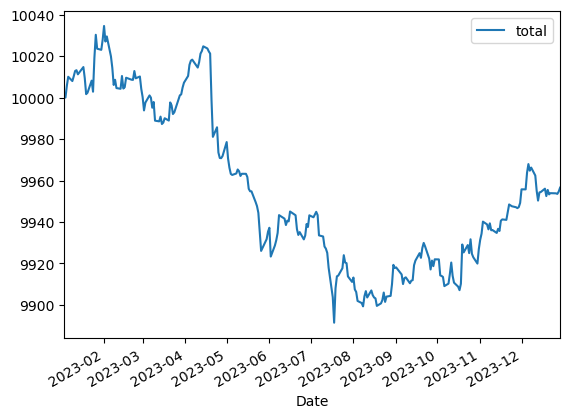

In [8]:
stock_T = Stock('T', df=None, start='2023-01-01',
                end='2023-12-31', save_new=False, debug=False)
stock_T.addStrategy(stock_T.buyStock(21))
stock_AAPL = Stock('AAPL', df=None, start='2023-01-01',
                   end='2023-12-31', save_new=True, debug=False)
stock_AAPL.addStrategy(stock_AAPL.buyStock(7, inDollars=True))

portfolio_instance = Portfolio(initial_capital=10000)
portfolio_instance.addStock(stock_T)
portfolio_instance.addStock(stock_AAPL)

portfolio_instance.backtest()
portfolio_instance.plotBacktest()
# portfolio_instance.backtest_df

In [9]:
portfolio_instance.backtest_df

,Date,T_total,T_position,AAPL_total,AAPL_position,total_strats,cash,total
0,2023-01-03,1000.00,0.0,1000.00,0.00,2000.00,8000,10000.00
1,2023-01-04,1000.00,21.0,1000.00,0.05,2000.00,8000,10000.00
2,2023-01-05,1005.67,21.0,1000.01,0.05,2005.68,8000,10005.68
3,2023-01-06,1010.08,21.0,999.95,0.05,2010.03,8000,10010.03
4,2023-01-09,1007.77,21.0,1000.19,0.05,2007.96,8000,10007.96
...,...,...,...,...,...,...,...,...
245,2023-12-22,950.23,21.0,1003.67,0.05,1953.90,8000,9953.90
246,2023-12-26,950.23,21.0,1003.58,0.05,1953.81,8000,9953.81
247,2023-12-27,950.02,21.0,1003.52,0.05,1953.54,8000,9953.54
248,2023-12-28,951.07,21.0,1003.61,0.05,1954.68,8000,9954.68


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


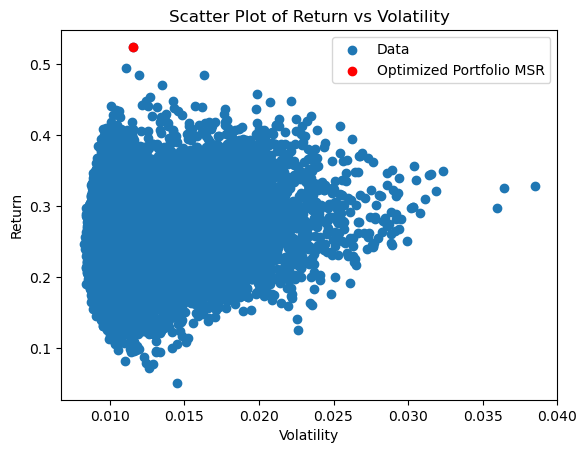

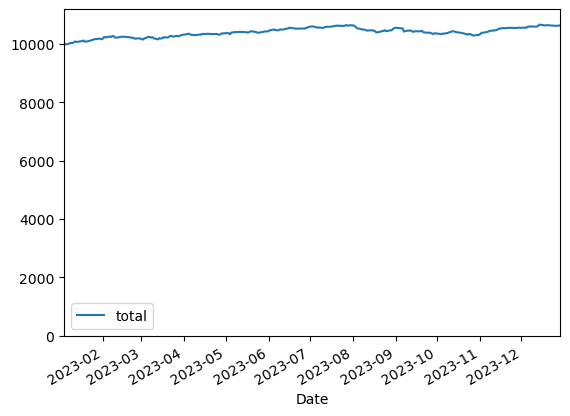

RETURNS STATS
pct_return: 0.06357099999999992
vol: 0.0021204973179822562
vol_annual: 0.03366185135496302
mean_daily_return: 0.00025079671136029263
mean_annual_return: 0.06523224660297822
skewness: -0.4802028628730352
excess_kurtosis: 2.064487966795098
shapiro: 0.9778520464897156(statistic), 0.0006467409548349679(pvalue)


,T_total,T_position,AAPL_total,AAPL_position,GME_total,GME_position,VTI_total,VTI_position,CGW_total,CGW_position,total_strats,cash,total,total_returns,cum_daily_return
Date,,,,,,,,,,,,,,,
2023-01-05,1000.10,0.38,1001.89,7.88,999.69,1.61,999.72,0.97,999.00,11.16,5000.40,5000,10000.40,0.000040,0.000040
2023-01-06,1000.18,0.38,993.06,7.88,997.98,1.61,999.62,0.97,1000.11,11.16,4990.95,5000,9990.95,-0.000945,-0.000905
2023-01-09,1000.14,0.38,1028.21,7.88,999.03,1.61,1003.82,0.97,1010.93,11.16,5042.13,5000,10042.13,0.005123,0.004213
2023-01-10,1000.18,0.38,1026.56,7.88,998.47,1.61,1002.07,0.97,1008.37,11.16,5035.65,5000,10035.65,-0.000645,0.003565
2023-01-11,1000.23,0.38,1034.36,7.88,1001.52,1.61,1004.87,0.97,1017.07,11.16,5058.05,5000,10058.05,0.002232,0.005805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,999.10,0.38,1538.18,7.88,999.24,1.61,1043.55,0.97,1058.79,11.16,5638.86,5000,10638.86,-0.000259,0.063886
2023-12-26,999.10,0.38,1525.81,7.88,999.56,1.61,1043.92,0.97,1060.13,11.16,5628.52,5000,10628.52,-0.000972,0.062852
2023-12-27,999.10,0.38,1516.98,7.88,1000.29,1.61,1044.91,0.97,1062.70,11.16,5623.98,5000,10623.98,-0.000427,0.062398


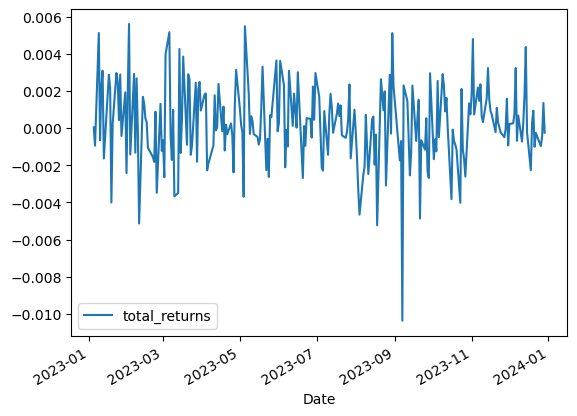

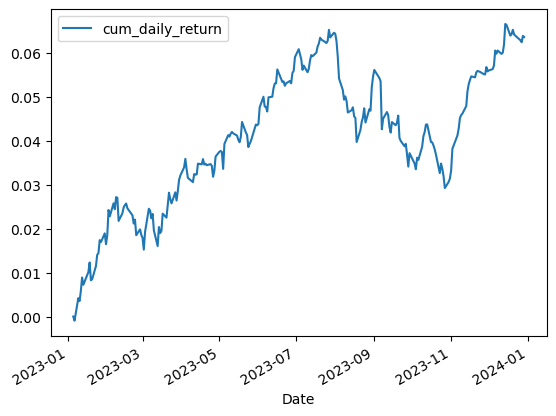

In [40]:
tickers = ['T', 'AAPL', 'GME', 'VTI', 'CGW']
portfolio_instance = Portfolio(
    tickers=tickers, start='2023-01-01', end='2023-12-31', initial_capital=10000)
# portfolio_instance.addStock('T')
# portfolio_instance.addStock('BABA')
# portfolio_instance.addStock('GME')
# portfolio_instance.addStock('CGW')
# portfolio_instance.addStock('VTI')

markov = portfolio_instance.markowitz(weight=100, plot=True, msr=True)
# print(markov)
portfolio_instance.backtest(plot=True, stats=True)
# first_stock = portfolio_instance.stocks[0]
# df = pd.DataFrame(index=first_stock.df[next(iter(first_stock.df))].index)

In [21]:
portfolio_instance.backtest_df.total
# portfolio_instance.backtest_df['total'].iloc[-1] - portfolio_instance.backtest_df['total'].iloc[0] / portfolio_instance.backtest_df['total'].loc[0]
# portfolio_instance.backtest_df['pct_return'] = ((portfolio_instance.backtest_df['total'].iloc[-1] - portfolio_instance.backtest_df['total'].iloc[0]) / portfolio_instance.backtest_df['total'].loc[0])

1      10000.00
2       9999.20
3       9988.40
4      10058.33
5      10043.93
         ...   
245    10827.00
246    10818.50
247    10818.65
248    10834.76
249    10831.71
Name: total, Length: 249, dtype: float64

In [30]:
markov[1]
# portfolio_instance.backtest_df

{'T': 2.0728749346691138,
 'AAPL': 68.970166578173,
 'GME': 6.06805293810701,
 'VTI': 22.161007267621287,
 'CGW': 0.7278982814296019}

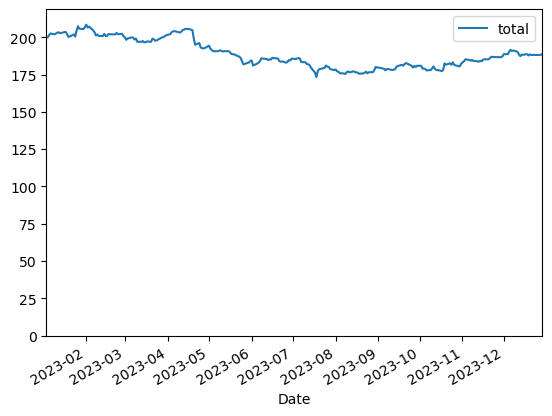

RETURNS STATS
{'vol': 0.006392175798895404, 'vol_annual': 0.10147264500289717, 'mean_daily_return': -0.00021053967126807125, 'mean_annual_return': -0.05167838993818785, 'skewness': -0.16087408047408608, 'excess_kurtosis': 2.733887655862393, 'shapiro': ShapiroResult(statistic=0.9625269770622253, pvalue=4.302373326936504e-06)}
MONTHLY PERCENTAGE RETURNS
              T_total    T_position  total_strats                 cash  \
Date                                                                     
2023-01  2.115543e+40  1.470390e+15  2.115543e+40  5609632319916218288   
2023-02  2.010857e+38  1.165571e+15  2.010857e+38  3160438431415629660   
2023-03  9.136518e+45  1.617651e+18  9.136518e+45  5062875838873911180   
2023-04  1.341218e+38  8.858222e+14  1.341218e+38  3160438431415629660   
2023-05  9.322611e+42  1.316217e+17  9.322611e+42  2059178818313653256   
2023-06  3.573242e+40  2.193695e+16  3.573242e+40 -5276201973458052908   
2023-07  1.659516e+38  3.656158e+15  1.659516e+38  560

,T_total,T_position,total_strats,cash,total,total_returns,cum_daily_return
Date,,,,,,,
2023-01-04,100.00,5.3,100.00,100,200.00,0.000000,0.00000
2023-01-05,101.43,5.3,101.43,100,201.43,0.007150,0.00715
2023-01-06,102.54,5.3,102.54,100,202.54,0.005511,0.01270
2023-01-09,101.96,5.3,101.96,100,201.96,-0.002864,0.00980
2023-01-10,102.54,5.3,102.54,100,202.54,0.002872,0.01270
...,...,...,...,...,...,...,...
2023-12-22,88.17,5.0,88.17,100,188.17,0.000798,-0.05915
2023-12-26,88.17,5.0,88.17,100,188.17,0.000000,-0.05915
2023-12-27,88.12,5.0,88.12,100,188.12,-0.000266,-0.05940


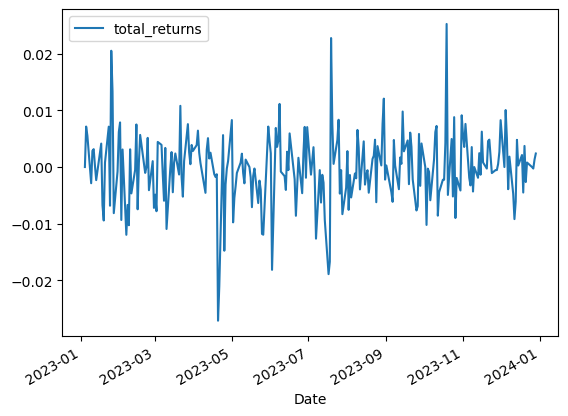

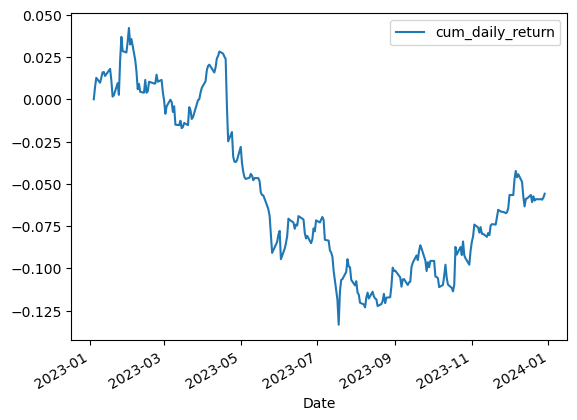

In [ ]:
# FF CAPM
initial_capital = 100
ticker = 'T'

stock_instance = Stock(
    ticker, df=None, initial_capital=initial_capital, save_new=False, debug=False)
stock_instance.addStrategy(stock_instance.buyStock(10))
stock_instance.addStrategy(stock_instance.macd(1, 15))
# stock_instance.backtest()
# stock_instance.saveToCSV()
# stock_instance2 = Stock('AAPL', df=None, initial_capital=initial_capital, save_new=False, debug=False)
# stock_instance2.addStrategy(stock_instance.buyStock(10))

portfolio_instance = Portfolio(initial_capital=200)
portfolio_instance.addStock(stock_instance)
# portfolio_instance.addStock(stock_instance2)
portfolio_instance.backtest(stats=True, plot=True)


# stock_instance.viewStrategies()
# stock_instance.strategies

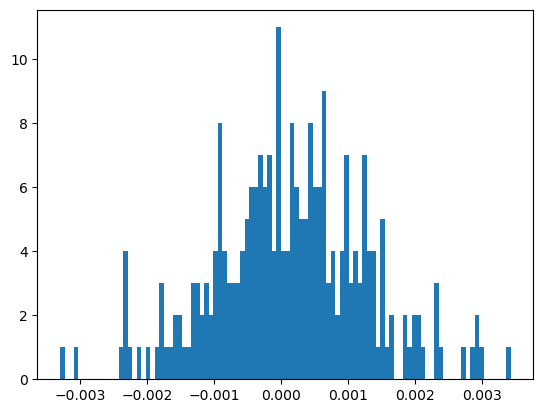

RETURNS STATS
{'vol': 0.001137087728845626, 'vol_annual': 0.018050708096332635, 'mean_daily_return': 0.00013064278348529838, 'mean_annual_return': 0.03346768396919364, 'skewness': -0.006589001730082176, 'excess_kurtosis': 0.2923210178551021, 'shapiro': ShapiroResult(statistic=0.9958363175392151, pvalue=0.7458564639091492)}
FF STATS
{'adjusted_r_squared': 0.6021770071110613, 'HML p value': 0.0057287508318210585, 'SMB p value': 0.04877948346207764, 'RMW p value': 0.9422958502650243, 'CMA p value': 0.050906235274785765, 'HML': -0.020022205793908086, 'SMB': 0.010511517311624773, 'RMW': -0.0004834116598266408, 'CMA': 0.016324637335276306, 'Alpha': -0.3883016806275692, 'Annual Alpha': '-0.997256', 'ann_alpha': -0.9972555997676714, 'Beta': -0.0016564878042832178}
SMB is statistically significant.
HML is statistically significant.


,T_total,T_position,MSFT_total,MSFT_position,AAPL_total,AAPL_position,total_strats,cash,total,total_returns,cum_daily_return
Date,,,,,,,,,,,
2023-01-04,3333.33,176.65,3333.33,13.71,3333.33,25.59,9999.99,90000.0,99999.99,0.000000,0.000000
2023-01-05,3381.03,176.65,3263.67,13.71,3339.47,25.59,9984.17,90000.0,99984.17,-0.000158,-0.000158
2023-01-06,3418.12,176.65,3206.08,13.71,3310.82,25.59,9935.02,90000.0,99935.02,-0.000492,-0.000650
2023-01-09,3398.69,176.65,3253.39,13.71,3424.93,25.59,10077.01,90000.0,100077.01,0.001421,0.000770
2023-01-10,3418.12,176.65,3271.35,13.71,3419.56,25.59,10109.03,90000.0,100109.03,0.000320,0.001090
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,2914.68,176.65,5272.34,13.71,5080.60,25.59,13267.62,90000.0,103267.62,-0.000028,0.032676
2023-12-26,2914.68,176.65,5290.44,13.71,5040.43,25.59,13245.55,90000.0,103245.55,-0.000214,0.032456
2023-12-27,2912.91,176.65,5272.48,13.71,5011.77,25.59,13197.16,90000.0,103197.16,-0.000469,0.031972


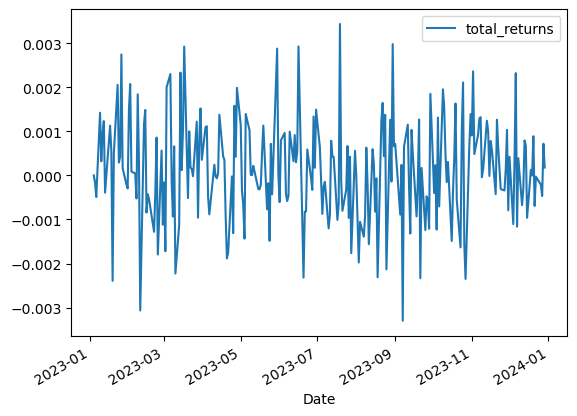

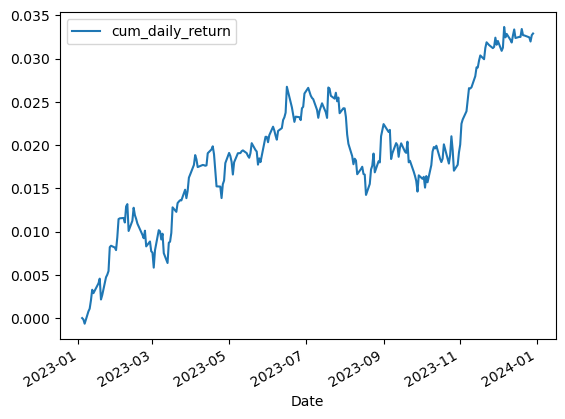

In [ ]:
port = Portfolio(initial_capital=100000, save_new=False)
port.equalWeightedPortfolio(['T', 'MSFT', 'AAPL'], capital=10000)
port.backtest(stats=True, ff_stats=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
For stock MSFT, weight=0.5324698367636622
For stock AAPL, weight=0.46753016323633784


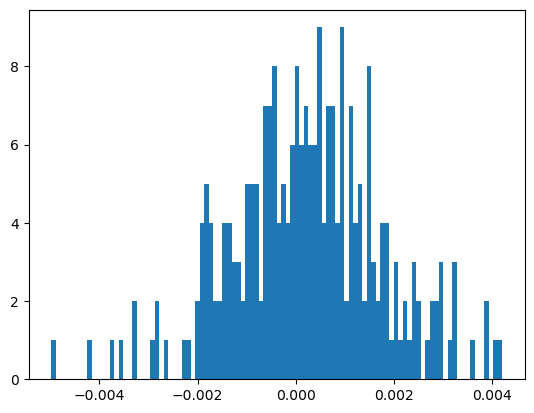

RETURNS STATS
pct_return: 0.055529599999999915
vol: 0.0015352374989875987
vol_annual: 0.024371139754451775
mean_daily_return: 0.00021824059820786616
mean_annual_return: 0.05653071532996057
skewness: -0.11521397410719304
excess_kurtosis: 0.41565983545811136
shapiro: 0.9940715432167053(statistic), 0.43625694513320923(pvalue)
FF STATS
adjusted_r_squared: 0.6032360093800513
HML p value: 0.005679600021018937
SMB p value: 0.05548014030007297
RMW p value: 0.8749722586558395
CMA p value: 0.048428497444656236
HML: -0.020672414621857586
SMB: 0.010417160559200285
RMW: -0.001083877397854538
CMA: 0.017077667705249665
Alpha: -0.38582536129818035
Annual Alpha: -0.997119
ann_alpha: -0.9971192700471141
Beta: -0.0016408230437959456
HML is statistically significant.
CMA is statistically significant.


,MSFT_total,MSFT_position,AAPL_total,AAPL_position,total_strats,cash,total,total_returns,cum_daily_return
Date,,,,,,,,,
2023-01-04,5324.70,21.91,4675.30,35.89,10000.00,90000.0,100000.00,0.000000,0.000000
2023-01-05,5213.42,21.91,4683.91,35.89,9897.33,90000.0,99897.33,-0.001027,-0.001027
2023-01-06,5121.42,21.91,4643.72,35.89,9765.14,90000.0,99765.14,-0.001323,-0.002349
2023-01-09,5196.99,21.91,4803.78,35.89,10000.77,90000.0,100000.77,0.002362,0.000008
2023-01-10,5225.69,21.91,4796.24,35.89,10021.93,90000.0,100021.93,0.000212,0.000219
...,...,...,...,...,...,...,...,...,...
2023-12-22,8422.08,21.91,7125.99,35.89,15548.07,90000.0,105548.07,-0.000080,0.055481
2023-12-26,8451.00,21.91,7069.65,35.89,15520.65,90000.0,105520.65,-0.000260,0.055207
2023-12-27,8422.30,21.91,7029.46,35.89,15451.76,90000.0,105451.76,-0.000653,0.054518


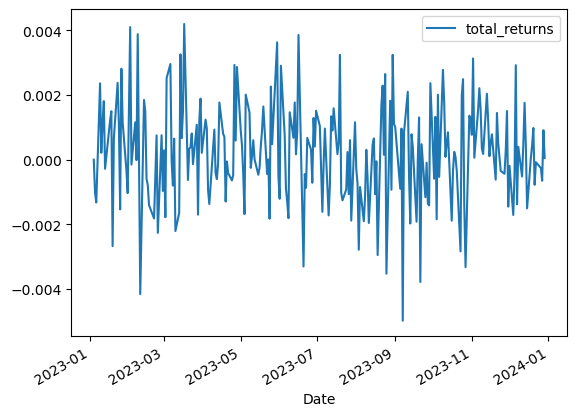

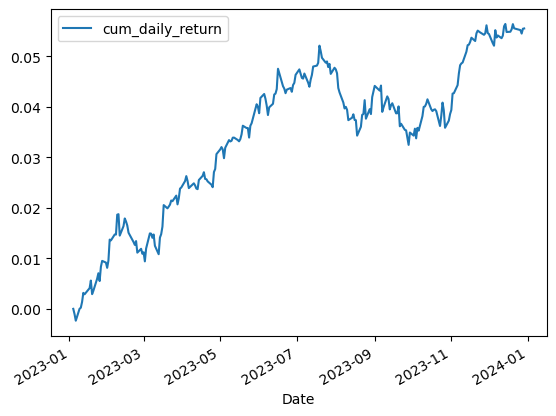

In [31]:
port = Portfolio(initial_capital=100000, start='2023-01-01',
                 end='2023-12-31', save_new=True, debug=False)
port.marketCapWeightedPortfolio(['MSFT', 'AAPL'], capital=10000)
port.backtest(stats=True, ff_stats=True)

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


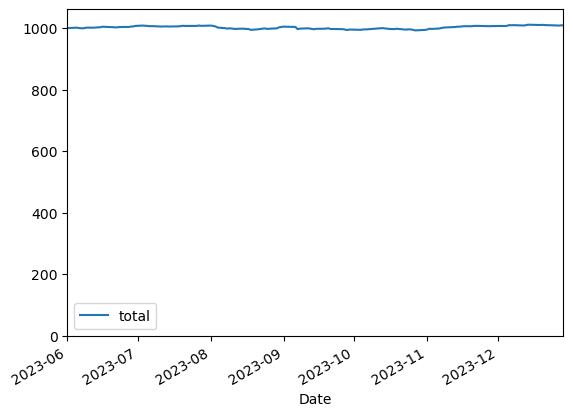

RETURNS STATS
pct_return: 0.008659999999999968
vol: 0.0012672982107519433
vol_annual: 0.020117735415640582
mean_daily_return: 5.986535815320941e-05
mean_annual_return: 0.015199981003657825
skewness: -1.3661283373021558
excess_kurtosis: 6.117848163277033
shapiro: 0.9247293472290039(statistic), 5.86583553285891e-07(pvalue)
FF STATS
adjusted_r_squared: -0.34982399807151854
HML p value: 0.8822925944603062
SMB p value: 0.5317419933714225
RMW p value: 0.9848408802827369
CMA p value: 0.7551837663452734
HML: -0.005036609845407313
SMB: 0.00802342659909301
RMW: -0.00027227826246095627
CMA: -0.013600798137891869
Alpha: -0.441632841943655
Annual Alpha: -0.999082
ann_alpha: -0.9990815862158077
Beta: 0.0007061146628151293


,T_total,T_position,AAPL_total,AAPL_position,total_strats,cash,total,total_returns,cum_daily_return
Date,,,,,,,,,
2023-06-02,100.00,1.0,100.00,0.55,200.00,800,1000.00,0.000000,0.00000
2023-06-05,100.25,1.0,100.88,0.55,201.13,800,1001.13,0.001130,0.00113
2023-06-06,100.38,1.0,99.41,0.55,199.79,800,999.79,-0.001338,-0.00021
2023-06-07,100.55,1.0,98.57,0.55,199.12,800,999.12,-0.000670,-0.00088
2023-06-08,100.96,1.0,98.27,0.55,199.23,800,999.23,0.000110,-0.00077
...,...,...,...,...,...,...,...,...,...
2023-12-22,101.42,1.0,107.82,0.55,209.24,800,1009.24,-0.000465,0.00924
2023-12-26,101.42,1.0,106.95,0.55,208.37,800,1008.37,-0.000862,0.00837
2023-12-27,101.41,1.0,106.33,0.55,207.74,800,1007.74,-0.000625,0.00774


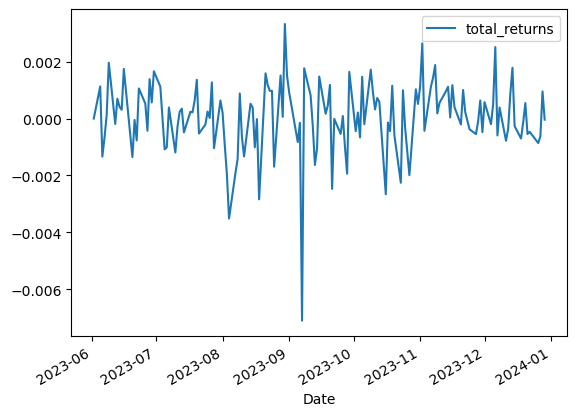

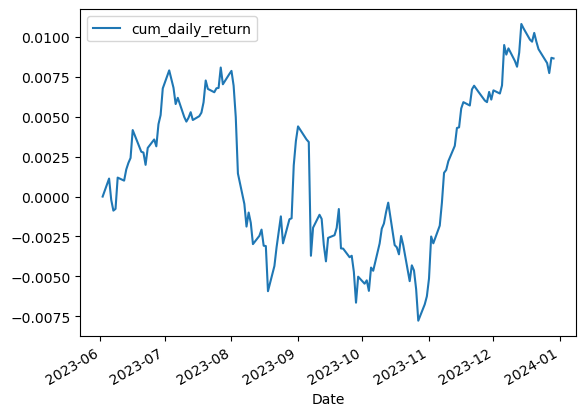

In [38]:
stock_T = Stock('T', start='2023-06-01', end='2024-01-01', initial_capital=100)
stock_T.addStrategy(stock_T.buyStock(1))
stock_AAPL = Stock('AAPL', start='2023-06-01',
                   end='2024-01-01', initial_capital=100)
stock_AAPL.addStrategy(stock_AAPL.buyStock(1))

portfolio_instance = Portfolio(
    start='2023-06-01', end='2024-01-01', initial_capital=1000)
portfolio_instance.addStock(stock_T)
portfolio_instance.addStock(stock_AAPL)

portfolio_instance.backtest(plot=True, ff_stats=True)
# portfolio_instance.plotBacktest()
# portfolio_instance.backtest_df